<a href="https://colab.research.google.com/github/albiagro/students-grade-prediction/blob/main/Student_Alcohol_Consumption.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Student Alcohol Consumption**

## **Data selection and pre-exploration**

In [ ]:
# Import necessary libs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, root_mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import wasserstein_distance
from tabulate import tabulate

!gdown 1ARlAyxG-sfczZFmS9Pg7LDqzXofcK1Te
df_student_por = pd.read_csv('student-por.csv')

pd.set_option('display.max_columns', None)

Downloading...
From: https://drive.google.com/uc?id=1ARlAyxG-sfczZFmS9Pg7LDqzXofcK1Te
To: /content/student-por.csv
100% 68.6k/68.6k [00:00<00:00, 42.7MB/s]


In [ ]:
# Display data
df_student_por.head(3)

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,course,mother,2,2,0,yes,no,no,no,yes,yes,no,no,4,3,4,1,1,3,4,0,11,11
1,GP,F,17,U,GT3,T,1,1,at_home,other,course,father,1,2,0,no,yes,no,no,no,yes,yes,no,5,3,3,1,1,3,2,9,11,11
2,GP,F,15,U,LE3,T,1,1,at_home,other,other,mother,1,2,0,yes,no,no,no,yes,yes,yes,no,4,3,2,2,3,3,6,12,13,12


In [ ]:
# Display columns
df_student_por.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 649 entries, 0 to 648
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   school      649 non-null    object
 1   sex         649 non-null    object
 2   age         649 non-null    int64 
 3   address     649 non-null    object
 4   famsize     649 non-null    object
 5   Pstatus     649 non-null    object
 6   Medu        649 non-null    int64 
 7   Fedu        649 non-null    int64 
 8   Mjob        649 non-null    object
 9   Fjob        649 non-null    object
 10  reason      649 non-null    object
 11  guardian    649 non-null    object
 12  traveltime  649 non-null    int64 
 13  studytime   649 non-null    int64 
 14  failures    649 non-null    int64 
 15  schoolsup   649 non-null    object
 16  famsup      649 non-null    object
 17  paid        649 non-null    object
 18  activities  649 non-null    object
 19  nursery     649 non-null    object
 20  higher    

None of the features have any null values. We can move forward.

## **Data transformation**

In [ ]:
# Rename columns for a better comprehension
columns_to_be_renamed = {'Pstatus': 'parent_status', 'Medu': 'mother_education', 'Fedu': 'father_education', 'Mjob': 'mother_job', 'Fjob': 'father_job', 'schoolsup': 'school_support', 'famsup': 'family_support',
                         'famrel': 'family_relationship', 'goout': 'go_out', 'Dalc': 'workday_alcohol_consumption', 'Walc': 'weekend_alcohol_consumption'}

df_student_por = df_student_por.rename(columns= columns_to_be_renamed)

In [ ]:
# Creating new columns describing categorical data (just for the EDA, I will drop them before to create the predictive model)
mother_education_labels = {
    0: "none",
    1: "prim. ed.",
    2: "5-9th grade",
    3: "sec. ed.",
    4: "higher ed."
}
df_student_por['mother_education_labels'] = df_student_por['mother_education'].map(mother_education_labels)
df_student_por['father_education_labels'] = df_student_por['father_education'].map(mother_education_labels)

traveltime_labels = {
    1: "<15 min.",
    2: "15 to 30 min.",
    3: "30 min. to 1 hour",
    4: ">1 hour"
}
df_student_por['traveltime_labels'] = df_student_por['traveltime'].map(traveltime_labels)

studytime_labels = {
    1: "<2 hours",
    2: "2 to 5 hours",
    3: "5 to 10 hours",
    4: ">10 hours"
}
df_student_por['studytime_labels'] = df_student_por['studytime'].map(studytime_labels)

alcohol_consumption_labels = {
    1: "very low",
    2: "low",
    3: "medium",
    4: "high",
    5: "very high"
}
df_student_por['workday_alcohol_consumption_labels'] = df_student_por['workday_alcohol_consumption'].map(alcohol_consumption_labels)
df_student_por['weekend_alcohol_consumption_labels'] = df_student_por['weekend_alcohol_consumption'].map(alcohol_consumption_labels)
df_student_por['freetime_labels'] = df_student_por['freetime'].map(alcohol_consumption_labels)
df_student_por['go_out_labels'] = df_student_por['go_out'].map(alcohol_consumption_labels)

health_labels = {
    1: "very bad",
    2: "bad",
    3: "good",
    4: "very good",
    5: "excellent"
}
df_student_por['health_labels'] = df_student_por['health'].map(health_labels)
df_student_por['family_relationship_labels'] = df_student_por['family_relationship'].map(health_labels)

# Defining their custom order for data visualization
custom_order = {
    "mother_education_labels": ["none", "prim. ed.", "5-9th grade", "sec. ed.", "higher ed."],
    "father_education_labels": ["none", "prim. ed.", "5-9th grade", "sec. ed.", "higher ed."],
    "traveltime_labels": ["<15 min.", "15 to 30 min.", "30 min. to 1 hour", ">1 hour"],
    "studytime_labels": ["<2 hours", "2 to 5 hours", "5 to 10 hours", ">10 hours"],
    "workday_alcohol_consumption_labels": ["very low", "low", "medium", "high", "very high"],
    "weekend_alcohol_consumption_labels": ["very low", "low", "medium", "high", "very high"],
    "freetime_labels": ["very low", "low", "medium", "high", "very high"],
    "go_out_labels": ["very low", "low", "medium", "high", "very high"],
    "health_labels": ["very bad", "bad", "good", "very good", "excellent"],
    "family_relationship_labels": ["very bad", "bad", "good", "very good", "excellent"]
}

## **Data exploration**

In [ ]:
df_student_por.head(3)

,school,sex,age,address,famsize,parent_status,mother_education,father_education,mother_job,father_job,reason,guardian,traveltime,studytime,failures,school_support,family_support,paid,activities,nursery,higher,internet,romantic,family_relationship,freetime,go_out,workday_alcohol_consumption,weekend_alcohol_consumption,health,absences,G1,G2,G3,mother_education_labels,father_education_labels,traveltime_labels,studytime_labels,workday_alcohol_consumption_labels,weekend_alcohol_consumption_labels,freetime_labels,go_out_labels,health_labels,family_relationship_labels
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,course,mother,2,2,0,yes,no,no,no,yes,yes,no,no,4,3,4,1,1,3,4,0,11,11,higher ed.,higher ed.,15 to 30 min.,2 to 5 hours,very low,very low,medium,high,good,very good
1,GP,F,17,U,GT3,T,1,1,at_home,other,course,father,1,2,0,no,yes,no,no,no,yes,yes,no,5,3,3,1,1,3,2,9,11,11,prim. ed.,prim. ed.,<15 min.,2 to 5 hours,very low,very low,medium,medium,good,excellent
2,GP,F,15,U,LE3,T,1,1,at_home,other,other,mother,1,2,0,yes,no,no,no,yes,yes,yes,no,4,3,2,2,3,3,6,12,13,12,prim. ed.,prim. ed.,<15 min.,2 to 5 hours,low,medium,medium,low,good,very good


**Features' type analysis**

---



**Ordinal categorical variables**
- mother_education (0 - none, 1 - primary education (4th grade), 2 – 5th to 9th grade, 3 – secondary education or 4 – higher education)
- father_education (same as mother_education)
- traveltime (1 - <15 min., 2 - 15 to 30 min., 3 - 30 min. to 1 hour, or 4 - >1 hour)
- studytime (1 - <2 hours, 2 - 2 to 5 hours, 3 - 5 to 10 hours, or 4 - >10 hours)
- family_relationship (from 1 - very bad to 5 - excellent)
- freetime (from 1 - very low to 5 - very high)
- go_out (from 1 - very low to 5 - very high)
- workday_alcohol_consumption (from 1 - very low to 5 - very high)
- weekend_alcohol_consumption (from 1 - very low to 5 - very high)
- health (from 1 - very bad to 5 - very good)


**Nominal categorical variables**
- school ('GP' - Gabriel Pereira or 'MS' - Mousinho da Silveira)
- sex - ('F' - female or 'M' - male)
- address ('U' - urban or 'R' - rural)
- famsize ('LE3' - less or equal to 3 or 'GT3' - greater than 3)
- parent_status ('T' - living together or 'A' - apart)
- mother_job ('teacher', 'health' care related, civil 'services' (e.g. administrative or police), 'at_home' or 'other')
- father_job (same as mother_job)
- reason (close to 'home', school 'reputation', 'course' preference or 'other')
- guardian ('mother', 'father' or 'other')

**Binary variables (yes/no)**
- school_support (extra educational support)
- family_support (family educational support)
- paid (extra paid classes within the course subject (Math or Portuguese))
- activities (extra-curricular activities)
- nursery (attended nursery school)
- higher (wants to take higher education)
- internet (Internet access at home)
- romantic (with a romantic relationship)

**Numerical variables**
- age (from 15 to 22)
- failures (from 0 to 4)
- absences (from 0 to 93)
- G1 (first period grade, from 0 to 20)
- G2 (second period grade, from 0 to 20)
- **G3 - target** (final grade, from 0 to 20)

In [ ]:
# Describe numerical variables only
df_student_por[['age', 'absences', 'G1', 'G2', 'G3']].describe()

,age,absences,G1,G2,G3
count,649.000000,649.000000,649.000000,649.000000,649.000000
mean,16.744222,3.659476,11.399076,11.570108,11.906009
std,1.218138,4.640759,2.745265,2.913639,3.230656
min,15.000000,0.000000,0.000000,0.000000,0.000000
25%,16.000000,0.000000,10.000000,10.000000,10.000000
50%,17.000000,2.000000,11.000000,11.000000,12.000000
75%,18.000000,6.000000,13.000000,13.000000,14.000000
max,22.000000,32.000000,19.000000,19.000000,19.000000


From the data below we can say that:
- We are analyzing people of 17 years old on average
- On average, the students loose only around 4 lessons out of 93
- On average, the students progressively increased their period grade (from G1 to G3)
- The students had an average final grade of 11.91 (out of 20), which is almost the sufficiency.

## **Univariate analysis**

In [ ]:
# Describe categorical ordinal variable studytime
df_student_por['studytime_labels'].value_counts().reindex(custom_order['studytime_labels'])

,count
studytime_labels,
<2 hours,212
2 to 5 hours,305
5 to 10 hours,97
>10 hours,35


We can say that most of the students spend less than 2 hours and from 2 to 5 hours per day on studies. Only 20% of the students spend more than 5 hours to study.

In [ ]:
# Describe categorical ordinal variable workday_alcohol_consumption
df_student_por['workday_alcohol_consumption_labels'].value_counts().reindex(custom_order['workday_alcohol_consumption_labels'])

,count
workday_alcohol_consumption_labels,
very low,451
low,121
medium,43
high,17
very high,17


In [ ]:
# Describe categorical ordinal variable weekend_alcohol_consumption
df_student_por['weekend_alcohol_consumption_labels'].value_counts().reindex(custom_order['weekend_alcohol_consumption_labels'])

,count
weekend_alcohol_consumption_labels,
very low,247
low,150
medium,120
high,87
very high,45


Let's compare data from a workday with weekend:
- 69,5% and of the students have a very low alcohol consumption during a workday and 18,6% of the students have a low consumption, which is in total 88,1%
- At weekend this data significantly change, as 41,6% of the students having a low-medium consumption.
- 20,3 % of the students have a high/very high consumption of alcohol during the weekend.

In [ ]:
# Describe categorical nominal variable parent_status
df_student_por['parent_status'].value_counts().sort_index()

,count
parent_status,
A,80
T,569


We can say parents are physically present in 87,7 % of the students (living together). Let's check their concrete contribution to the students.

In [ ]:
# Describe binary variable family_support
df_student_por['family_support'].value_counts().sort_index()

,count
family_support,
no,251
yes,398


Only 61,3 % of the students get support by their family. We will analyze later whether some feature like studytime, workday_alcohol_consumption or weekend_alcohol_consumption can be affected from this lack of support.

At first, let's check the target variable's distribution. This will be useful, later, to understand what ML model and performance metrics to be used.

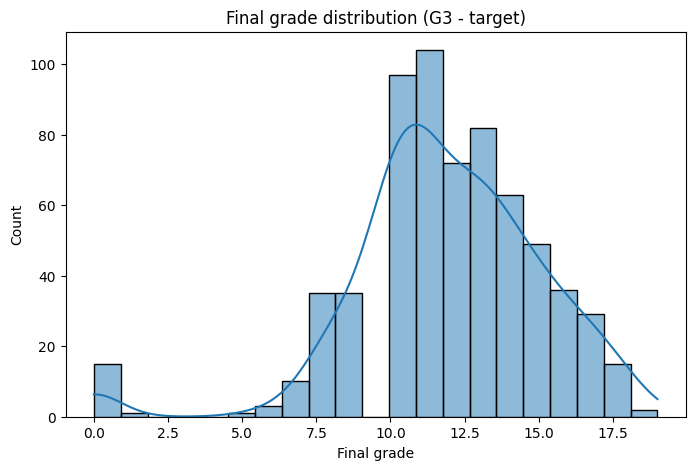

In [ ]:
# Plot G3 (final grade) distribution
plt.figure(figsize=(8, 5))
sns.histplot(data=df_student_por['G3'], kde=True)
plt.title('Final grade distribution (G3 - target)')
plt.xlabel('Final grade')
plt.ylabel('Count')
plt.show()

The target variable has a normal slightly asymmetric distribution, with visible outliers at grade < 2.5 and a mean around 12 as expected. Let's understand why such low grades.

In [ ]:
very_bad_students = df_student_por[df_student_por['G3'] <= 2.5]
very_bad_students

,school,sex,age,address,famsize,parent_status,mother_education,father_education,mother_job,father_job,reason,guardian,traveltime,studytime,failures,school_support,family_support,paid,activities,nursery,higher,internet,romantic,family_relationship,freetime,go_out,workday_alcohol_consumption,weekend_alcohol_consumption,health,absences,G1,G2,G3,mother_education_labels,father_education_labels,traveltime_labels,studytime_labels,workday_alcohol_consumption_labels,weekend_alcohol_consumption_labels,freetime_labels,go_out_labels,health_labels,family_relationship_labels
163,GP,M,18,U,LE3,T,1,1,other,other,course,mother,1,1,2,no,no,no,no,yes,no,yes,yes,2,3,5,2,5,4,0,11,9,0,prim. ed.,prim. ed.,<15 min.,<2 hours,low,very high,medium,very high,very good,bad
172,GP,M,16,U,GT3,T,3,3,other,services,course,father,1,2,1,no,yes,no,no,yes,yes,yes,yes,4,5,5,4,4,5,0,10,10,1,sec. ed.,sec. ed.,<15 min.,2 to 5 hours,high,high,very high,very high,excellent,very good
440,MS,M,16,U,GT3,T,1,1,at_home,services,home,mother,2,2,0,no,yes,no,yes,yes,yes,no,yes,5,4,5,4,5,3,0,7,0,0,prim. ed.,prim. ed.,15 to 30 min.,2 to 5 hours,high,very high,high,very high,good,excellent
519,MS,M,16,R,GT3,T,2,1,other,services,reputation,mother,2,2,0,no,no,no,yes,yes,yes,yes,no,5,2,1,1,1,2,0,8,7,0,5-9th grade,prim. ed.,15 to 30 min.,2 to 5 hours,very low,very low,low,very low,bad,excellent
563,MS,M,17,U,GT3,T,2,2,other,other,course,mother,1,1,1,no,no,no,yes,yes,yes,no,yes,1,2,1,2,3,5,0,7,0,0,5-9th grade,5-9th grade,<15 min.,<2 hours,low,medium,low,very low,excellent,very bad
567,MS,M,18,R,GT3,T,3,2,services,other,course,mother,1,1,1,no,no,no,no,yes,no,yes,no,2,3,1,2,2,5,0,4,0,0,sec. ed.,5-9th grade,<15 min.,<2 hours,low,low,medium,very low,excellent,bad
583,MS,F,18,R,GT3,T,2,2,other,other,other,mother,2,1,1,no,no,no,no,yes,no,yes,yes,5,5,5,1,1,3,0,8,6,0,5-9th grade,5-9th grade,15 to 30 min.,<2 hours,very low,very low,very high,very high,good,excellent
586,MS,F,17,U,GT3,T,4,2,teacher,services,home,mother,1,2,0,yes,yes,no,yes,yes,yes,yes,no,5,5,5,1,3,5,0,8,8,0,higher ed.,5-9th grade,<15 min.,2 to 5 hours,very low,medium,very high,very high,excellent,excellent
597,MS,F,18,R,GT3,T,2,2,at_home,other,course,mother,3,2,1,no,no,no,yes,yes,yes,no,yes,4,3,3,1,1,4,0,9,0,0,5-9th grade,5-9th grade,30 min. to 1 hour,2 to 5 hours,very low,very low,medium,medium,very good,very good
603,MS,F,18,R,LE3,A,4,2,teacher,other,reputation,mother,1,2,0,no,no,no,yes,yes,yes,yes,yes,5,3,1,1,1,5,0,5,0,0,higher ed.,5-9th grade,<15 min.,2 to 5 hours,very low,very low,medium,very low,excellent,excellent


In [ ]:
# I suppose the time spent to study is not too high
very_bad_students['studytime_labels'].value_counts().sort_index()

,count
studytime_labels,
2 to 5 hours,8
<2 hours,8


In [ ]:
# Maybe they had low support from the family? I guess yes.
very_bad_students['family_support'].value_counts().sort_index()

,count
family_support,
no,11
yes,5


In [ ]:

# Let's check whether their performance could be caused by alcohol consumption
very_bad_students['workday_alcohol_consumption_labels'].value_counts()

,count
workday_alcohol_consumption_labels,
very low,8
low,4
high,4


In [ ]:
# Let's check whether their performance could be caused by alcohol consumption
very_bad_students['weekend_alcohol_consumption_labels'].value_counts().reindex(custom_order['weekend_alcohol_consumption_labels'])

,count
weekend_alcohol_consumption_labels,
very low,4
low,2
medium,6
high,2
very high,2


In [ ]:
# Let's see whether health could be involved
very_bad_students['health_labels'].value_counts().reindex(custom_order['health_labels'])

,count
health_labels,
very bad,1
bad,2
good,3
very good,2
excellent,8


Below some food for thought:
- 14 out of 16 students belong to MS school.
- They are equally distributed between males and females.
- All the students spent less than 5 hours on studies, but 50% of them spent from 2 to 5 hours per day, which is not bad.
- 11 out of 16 students did not have support from their family.
- Alcohol consumption and health do not seem to have a significant impact on these results.
- The strange thing is that none of them had neither an absence during the whole course.

As it is not very clear to understand the reason of these final grades, we will check the correlation between the variables, using the whole dataset though (as we do not have much data here).

## **Multivariate analysis**

We will start by analyzing the correlation between the alcohol consumption and the final grade. Although for the previous "bad" students the alcohol consumption did not play a crucial role, it is legit to check it. I'm expecting it will be involved on their performances.

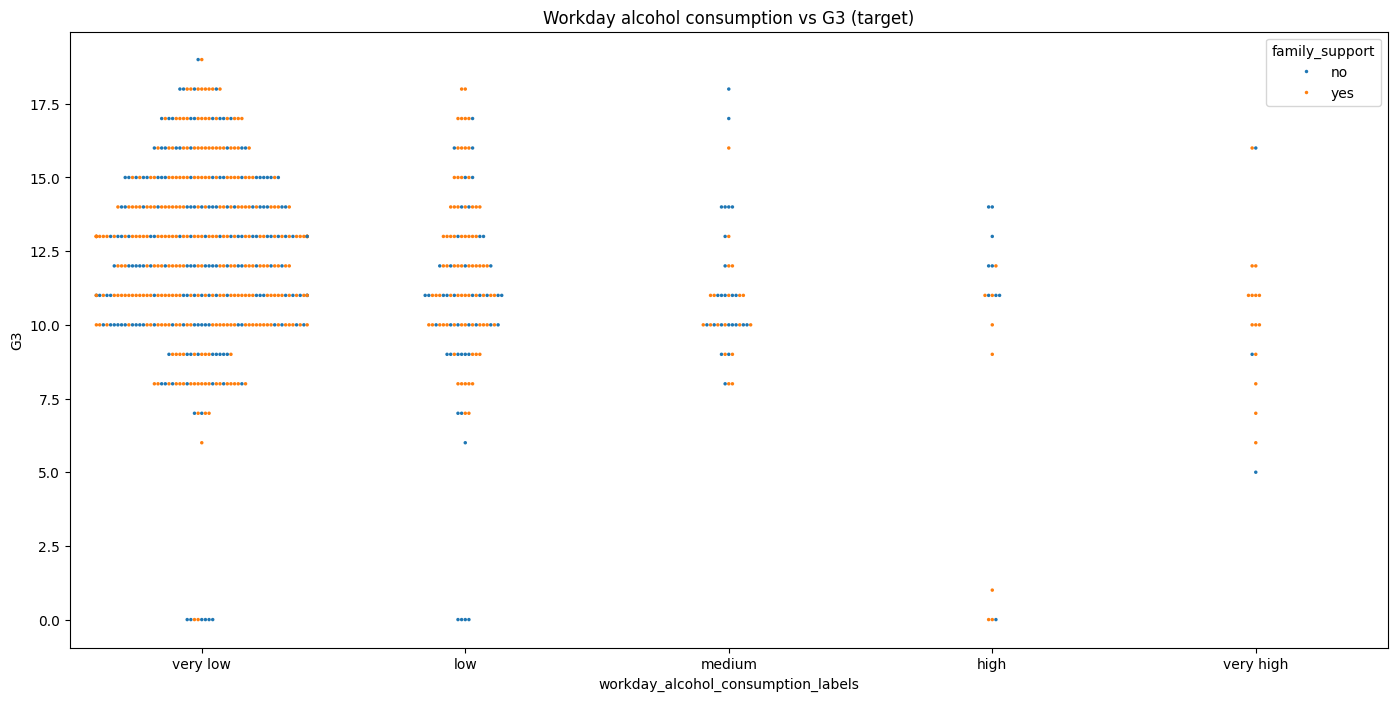

In [ ]:
plt.figure(figsize=(17, 8))
sns.swarmplot(data=df_student_por, x="workday_alcohol_consumption_labels", y="G3", hue="family_support", size=2.5, order=custom_order['workday_alcohol_consumption_labels'])
plt.title('Workday alcohol consumption vs G3 (target)')
plt.show()

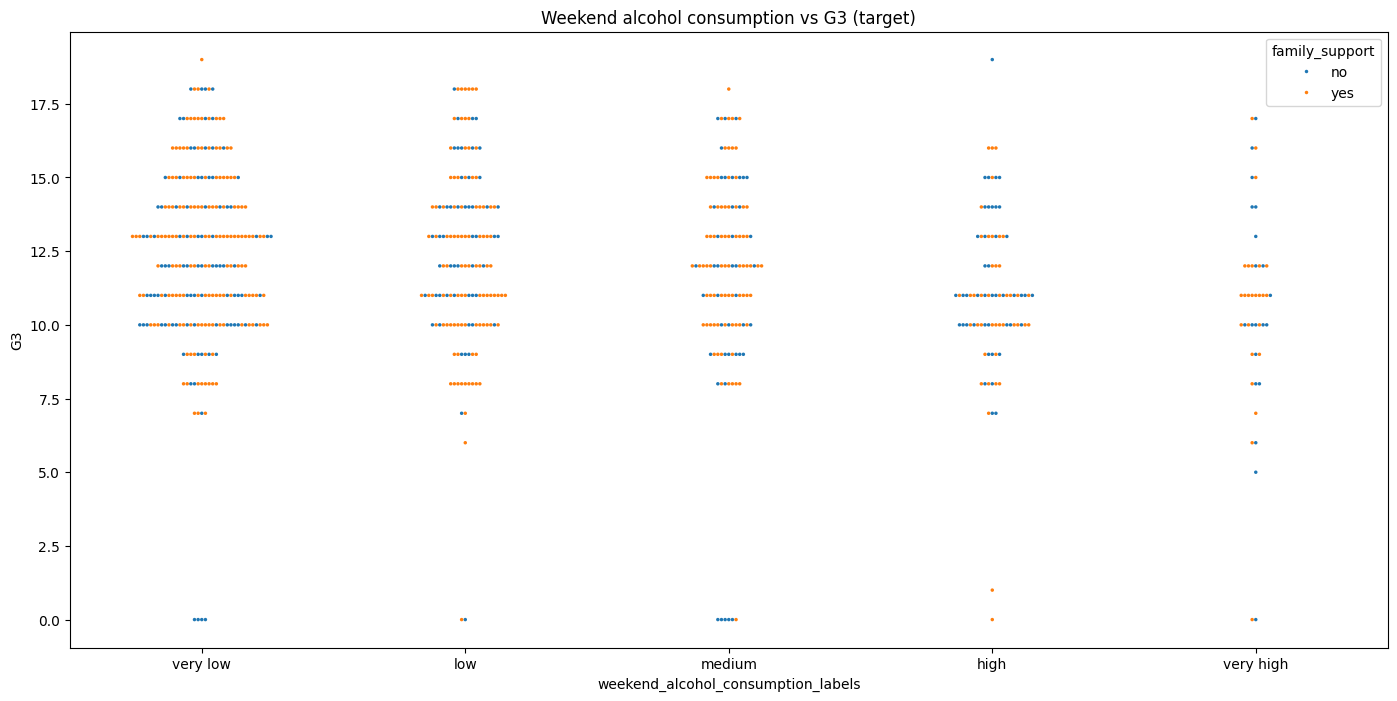

In [ ]:
plt.figure(figsize=(17, 8))
sns.swarmplot(data=df_student_por, x="weekend_alcohol_consumption_labels", y="G3", hue="family_support", size=2.5, order=custom_order['weekend_alcohol_consumption_labels'])
plt.title('Weekend alcohol consumption vs G3 (target)')
plt.show()

We can confirm the alcohol consumption's impact is relevant, especially for high and very high values, which their higher distribution of values is much less than very low consumers.
However, the family support does not have a significant impact: for example, almost all the students who have a very high workday alcohol consumption have family support. Similarly, most of the students who obtained a lower G3 (less than 11, the mean) had family support, so that's not the cause.
Only the worst students (final G3 less than 2.5), how we analyzed previously, had a relevant lack of family support.

In [ ]:
# Defining a generic function to plot categorical variables (I will use it for ordinal, nominal and binary categorical variables)

def multipleBoxplot(num_columns, variables, fig_width, fig_height, custom_order_active=False, target='G3'):
  # Set the number of columns (e.g., 2 per row)
  num_columns = num_columns
  num_variables = len(variables)
  num_rows = int(np.ceil(num_variables / num_columns))  # Automatically determine required rows

  # Create subplots with multiple columns
  fig, axes = plt.subplots(num_rows, num_columns, figsize=(fig_width, fig_height))

  # Flatten axes array to make iteration easier
  axes = axes.flatten()

  # Generate boxplots for each categorical variable
  for i, var in enumerate(variables):
      # Applying custom order for le-labeled variables
      if custom_order_active == True:
        order_to_be_applied = custom_order[var]
      else:
        order_to_be_applied = sorted(df_student_por[var].unique())

      sns.boxplot(x=var, y=target, data=df_student_por, ax=axes[i], hue=var, legend=False, width=0.5, order=order_to_be_applied)
      axes[i].set_title(f"Boxplot of {var} vs {target}")

  # Remove empty subplots if the number of variables is odd
  for j in range(i + 1, len(axes)):
      fig.delaxes(axes[j])

  plt.tight_layout()
  plt.show()

We will start analyzing the impact of the main categorical variables on the final grade. I'm expecting parents' education, studytime and go_out to be the most decisive ones.

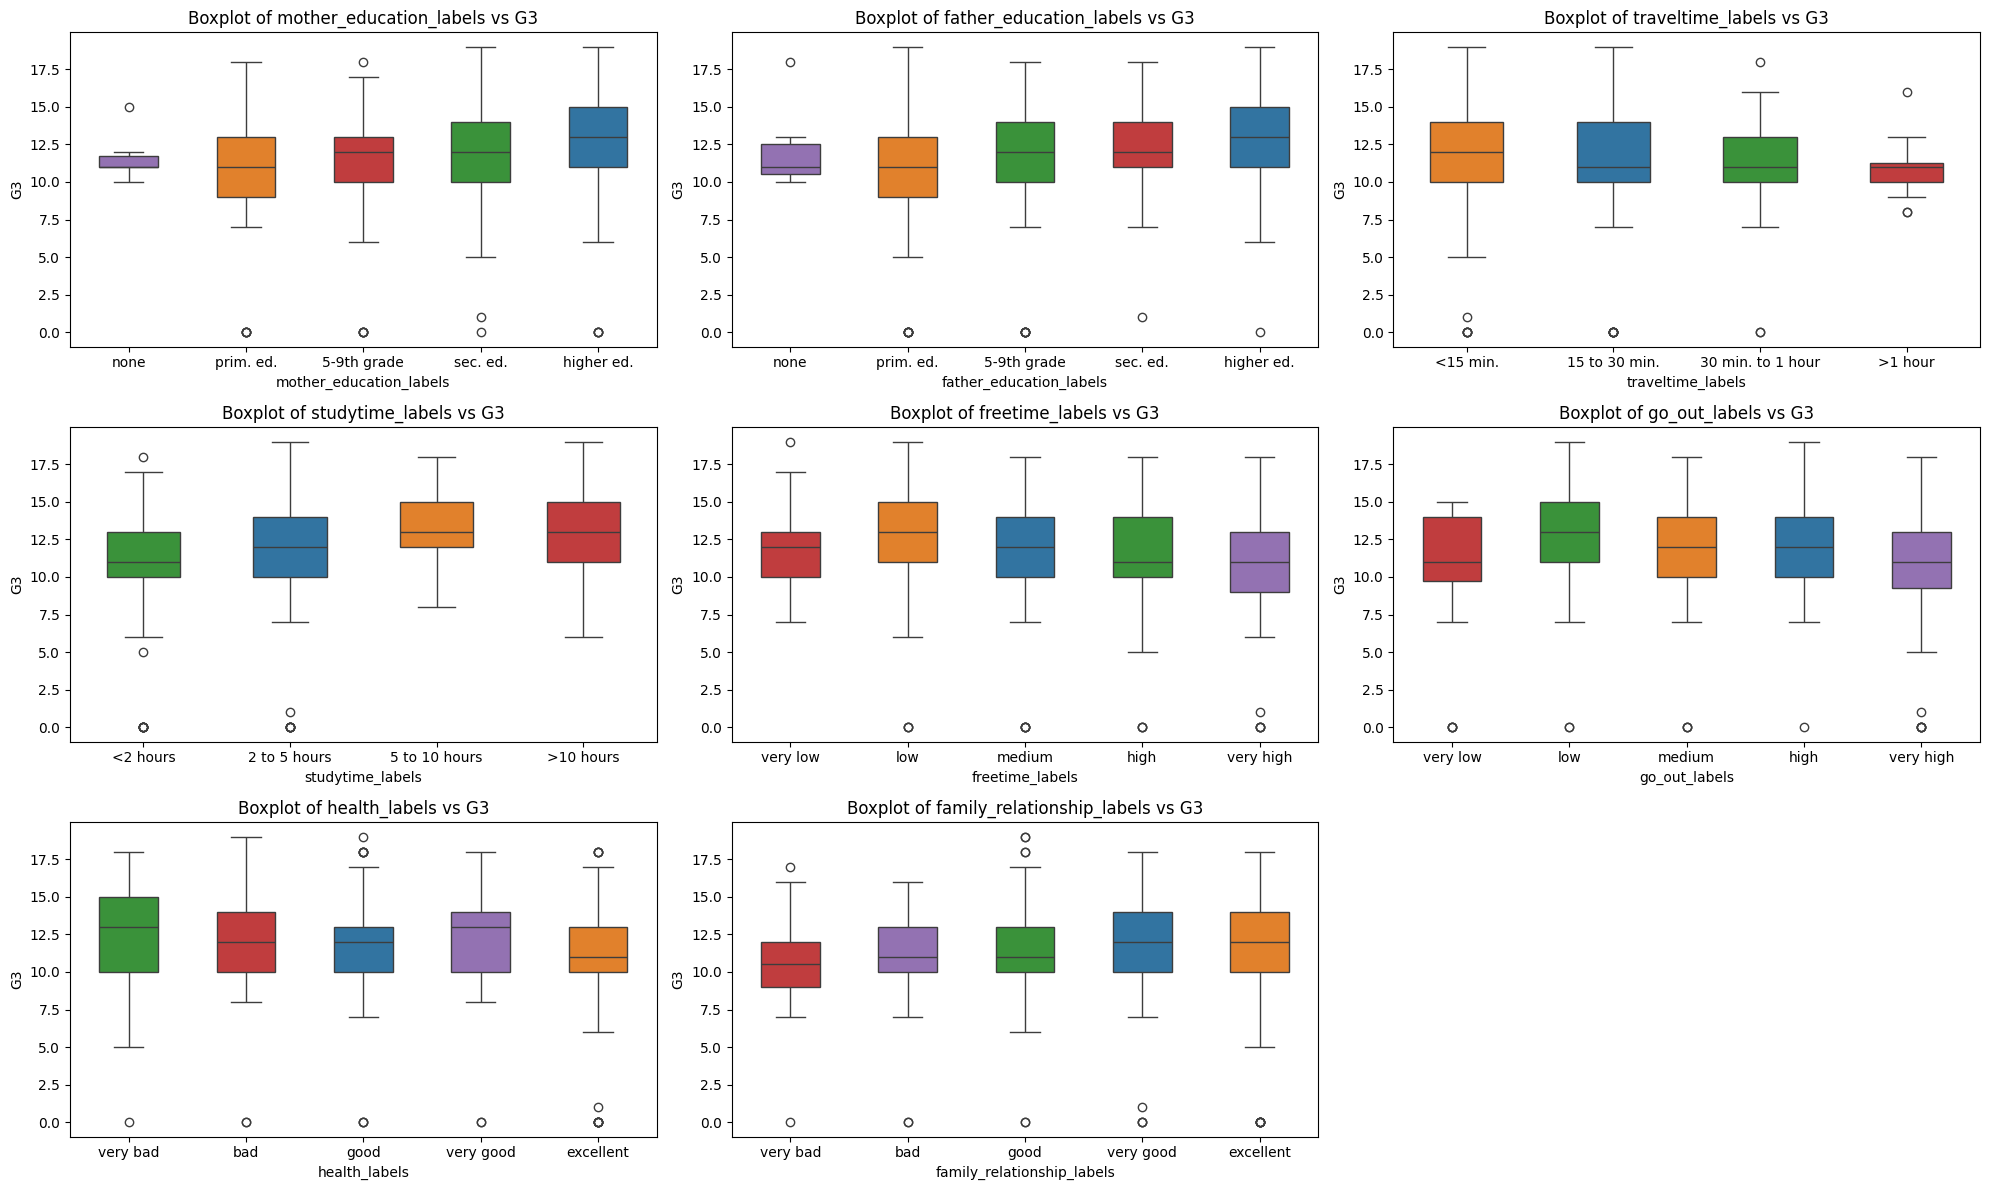

In [ ]:
# Plotting ordinal categorical variables
variables = ["mother_education_labels", "father_education_labels", "traveltime_labels", "studytime_labels", "freetime_labels", "go_out_labels", "health_labels", "family_relationship_labels"]

multipleBoxplot(3, variables, 20, 12, True)

As we could imagine, parents' education level is highly decisive on the students' final grade. Travel time is a surprise and it has an high impact as well, as the students who travel more has a lower range of values compared to the students closer to the school.
Studytime is another surprise, as people who studied more than 10 hours has not an high difference from people who studied 5-10 hours, as an example.
Similarly, another fun thing is that people who went out with very low frequency did not perform better than people who went out with low frequency (which is the top class) and it suggests that going out with the right dose is healthier for the performance.
Health and family relationships have not very impressive data to explain.

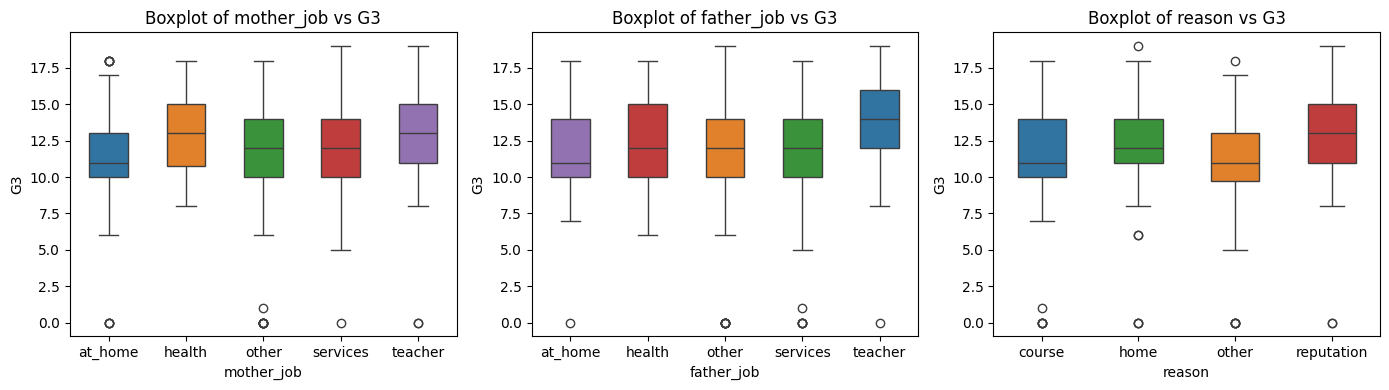

In [ ]:
# Plotting nominal categorical variables
variables = ["mother_job", "father_job", "reason"]

multipleBoxplot(3, variables, 14, 4)

We can see health and teacher leading the impacts of jobs on the students' performance. Moreover, students who chose the school for reputation performs better.

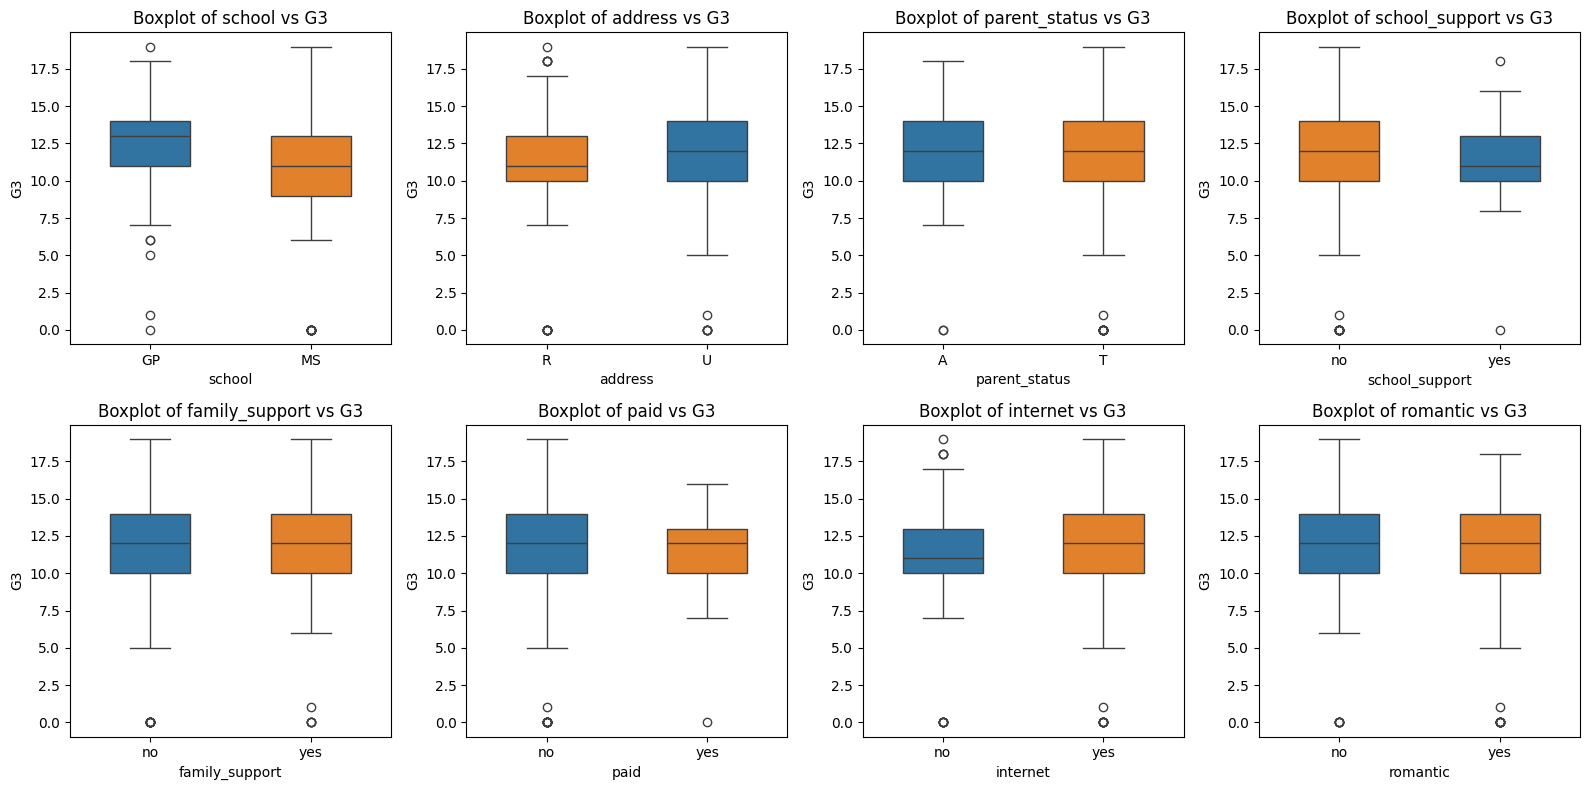

In [ ]:
# Plotting binary variables
variables = ["school", "address", "parent_status", "school_support", "family_support", "paid", "internet", "romantic"]

multipleBoxplot(4, variables, 16, 8)

Below the most significant insights:
- GP's students did much better than MS's
- Students coming from urban addresses performed slightly better
- People who received school support did not get an higher final grade
- Internet access has a significant positive impact on the final grade
- People who don't have a relationship did a bit better.

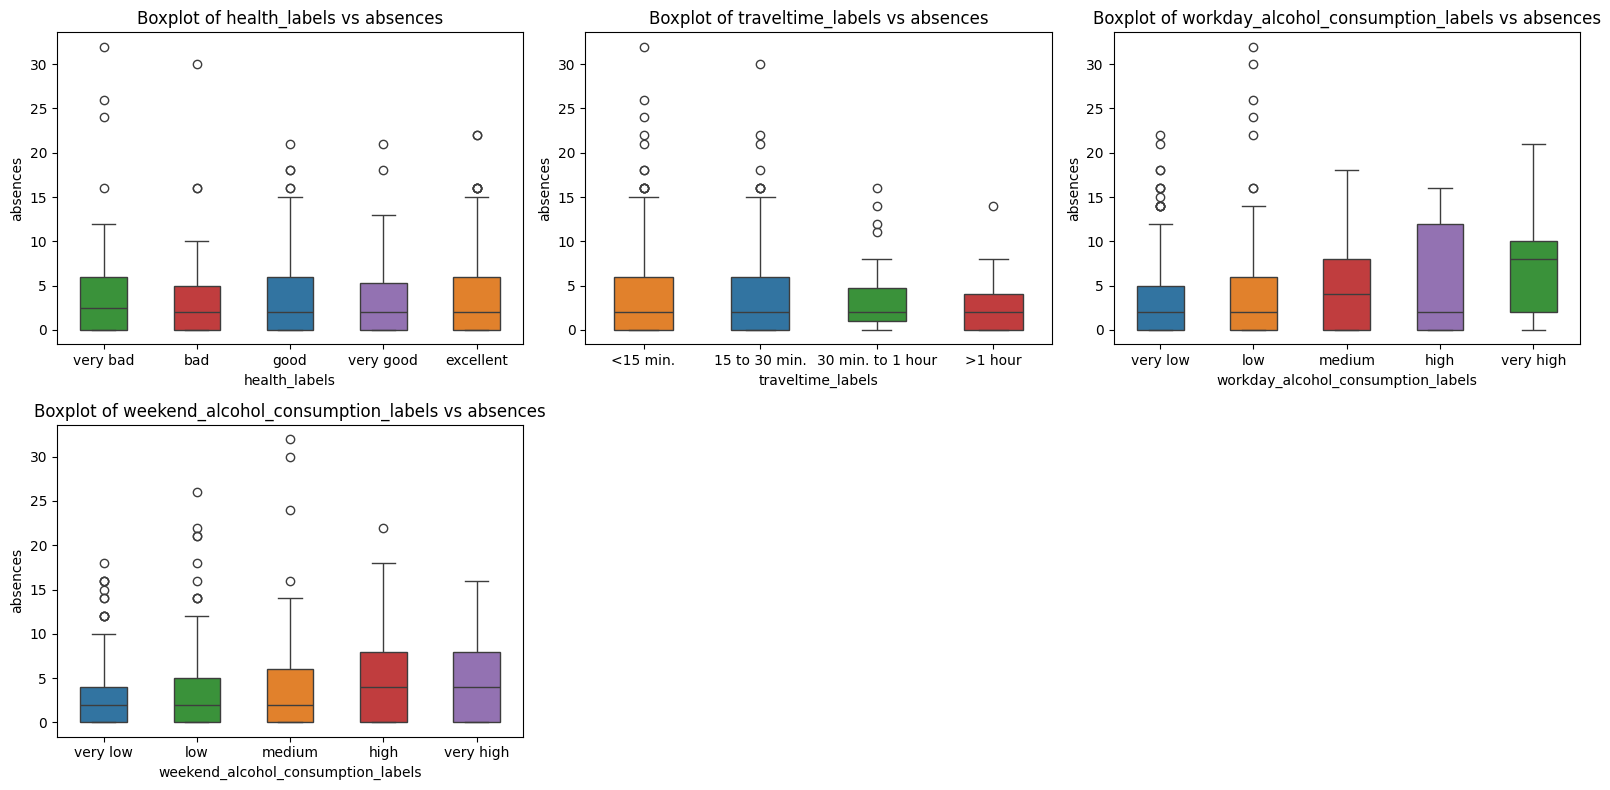

In [ ]:
# Plotting possible causes of absences. I'm expecting health and workday alcohol consumption to have higher impacts
variables = ["health_labels", "traveltime_labels", "workday_alcohol_consumption_labels", "weekend_alcohol_consumption_labels"]

multipleBoxplot(3, variables, 16, 8, True, 'absences')

From the plots above, we can say that:
- People with very bad health did not have much more absences than other people, even if there are more outliers.
- On average all the students lost few lessons, but weekend and workday (especially the last one) alcohol consumption had a very high impact on their absences.

In [ ]:
# Removing descriptive columns created by me
for col in df_student_por.columns:
    if 'labels' in col:  # Corretto il controllo della sottostringa
        df_student_por.drop(col, axis=1, inplace=True)

In [ ]:
# Transform categorical data

# Nominal features
nominal_features = ['mother_job', 'father_job', 'reason', 'guardian']
df_student_por = pd.get_dummies(df_student_por, columns = nominal_features) # One-hot encoding for nominal columns

# Binary features
binary_features = ['school', 'sex', 'address', 'famsize', 'parent_status', 'school_support', 'family_support', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic']
le = LabelEncoder()
for feature in binary_features:
  df_student_por[feature] = le.fit_transform(df_student_por[feature])

# Renaming some binary features for a better comprehension
df_student_por = df_student_por.rename(columns= {'address':'address_urban', 'famsize': 'famsize_less_than_3', 'parent_status': 'parent_living_together', 'school': 'school_MS'})

# Converting true/false to 1/0
df_student_por = df_student_por.astype(int)

In [ ]:
df_student_por.head(3)

,school_MS,sex,age,address_urban,famsize_less_than_3,parent_living_together,mother_education,father_education,traveltime,studytime,failures,school_support,family_support,paid,activities,nursery,higher,internet,romantic,family_relationship,freetime,go_out,workday_alcohol_consumption,weekend_alcohol_consumption,health,absences,G1,G2,G3,mother_job_at_home,mother_job_health,mother_job_other,mother_job_services,mother_job_teacher,father_job_at_home,father_job_health,father_job_other,father_job_services,father_job_teacher,reason_course,reason_home,reason_other,reason_reputation,guardian_father,guardian_mother,guardian_other
0,0,0,18,1,0,0,4,4,2,2,0,1,0,0,0,1,1,0,0,4,3,4,1,1,3,4,0,11,11,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0
1,0,0,17,1,0,1,1,1,1,2,0,0,1,0,0,0,1,1,0,5,3,3,1,1,3,2,9,11,11,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0
2,0,0,15,1,1,1,1,1,1,2,0,1,0,0,0,1,1,1,0,4,3,2,2,3,3,6,12,13,12,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0


Now we just have numerical data, we can move ahead analyzing the correlation among variables.

In [ ]:
# Calculate the correlation matrix
corr_matrix = df_student_por.corr()

# Threshold to consider only strong correlations
threshold = 0.3

# Convert the matrix into a long-format DataFrame ("melted" format)
corr_pairs = corr_matrix.unstack().reset_index()
corr_pairs.columns = ["Variable 1", "Variable 2", "Correlation"]

# Remove self-correlations (where a variable is correlated with itself)
corr_pairs = corr_pairs[corr_pairs["Variable 1"] != corr_pairs["Variable 2"]]

# Keep only correlations above the threshold
strong_corr = corr_pairs[abs(corr_pairs["Correlation"]) > threshold]

# Sort by absolute correlation value, from highest to lowest
strong_corr = strong_corr.sort_values(by="Correlation", ascending=False)

# Display the full table
pd.set_option('display.max_rows', None)
print(strong_corr)

                       Variable 1                   Variable 2  Correlation
1315                           G3                           G2     0.918548
1270                           G2                           G3     0.918548
1223                           G1                           G2     0.864982
1268                           G2                           G1     0.864982
1314                           G3                           G1     0.826387
1224                           G1                           G3     0.826387
328              father_education             mother_education     0.647477
283              mother_education             father_education     0.647477
1080  weekend_alcohol_consumption  workday_alcohol_consumption     0.616561
1035  workday_alcohol_consumption  weekend_alcohol_consumption     0.616561
1524           mother_job_teacher             mother_education     0.449847
309              mother_education           mother_job_teacher     0.449847
989         

Just to avoid confusioning plot, I have just analyzed the most significant correlations and we can see that:
- People who both have an high educational level will tend to be together (with reference to the correlation between mother and father education).
- Students who consume alcohol during workdays, tend to do the same in the weekend (and viceversa).
- Mothers with higher educational level are more likely to be teachers (0.45 out of 1), while the ones with lower educational level are more likely to be at home.
- GP's students are mostly coming from urban addresses.
- Males tend to consume more alcohol than females.
- Males are slightly more correlated to failures.

Without considering G1 and G2 (not being social/personal data but mid-term results), the most significant variables for our target (G3) are:
- Higher: students who are planning to attend an higher school performed better.
- Failures: the less failures, the better was G3. Failures are correlated to higher as well.


We are ready to start to predict the students' final grade!

## **Data prediction**

In [ ]:
# Extracting the target feature from the dataset
y = df_student_por['G3']

# Removing the target and useless variables
X = df_student_por.drop(columns=['G3', 'G1', 'G2', 'failures', 'absences'])

In addiction to the target, I removed variables that would fake the final prediction: G1, G2, failures and absences. These are students' mid-term results and they will obviously fake the final prediction, also according to their strong correlation with the target. I just want to focus on social/personal students' information. I will now check again the correlation with the target using mutual information which allows to find non-linear relationships.  

In [ ]:
mi_scores = mutual_info_regression(X, y, random_state=42)

# Ordering for features' importance
feature_importance = dict(zip(X.columns, mi_scores))
sorted_features = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)
columns_to_be_removed = []

for feature, score in sorted_features:
    print(f"Feature: {feature}, MI Score: {score}")
    if score == 0:
        columns_to_be_removed.append(feature)

Feature: studytime, MI Score: 0.07736246529303692
Feature: higher, MI Score: 0.06713913678590488
Feature: school_MS, MI Score: 0.06454884036156816
Feature: weekend_alcohol_consumption, MI Score: 0.060402560629202906
Feature: mother_job_teacher, MI Score: 0.05906754394385327
Feature: workday_alcohol_consumption, MI Score: 0.053044398149490135
Feature: age, MI Score: 0.04359331844510894
Feature: traveltime, MI Score: 0.04194713152491092
Feature: sex, MI Score: 0.03975353948575533
Feature: father_education, MI Score: 0.03963750374863029
Feature: address_urban, MI Score: 0.037237371916118533
Feature: reason_course, MI Score: 0.033787141085475536
Feature: guardian_father, MI Score: 0.030303099998025385
Feature: reason_home, MI Score: 0.028985185684588632
Feature: go_out, MI Score: 0.025876827734674368
Feature: mother_education, MI Score: 0.024886743282674928
Feature: guardian_other, MI Score: 0.022161298071920132
Feature: reason_reputation, MI Score: 0.0218009174066065
Feature: reason_other

We will remove features with 0 relationship and useless in order to reduce features' number and improve the model's training.

In [ ]:
X = X.drop(columns=columns_to_be_removed)

In [ ]:
# Creating bins to stratify the target variable
y_binned = pd.qcut(y, q=10, duplicates="drop")  # More bins for more precise stratification

best_split = None
best_distance = float("inf")

for seed in range(10, 1000, 10):  # Testing multiple random_state values
    X_train_tmp, X_test_tmp, y_train_tmp, y_test_tmp = train_test_split(
        X, y, test_size=0.30, stratify=y_binned, random_state=seed
    )

    # Comparing the distribution between train and test
    distance = wasserstein_distance(y_train_tmp, y_test_tmp)

    if distance < best_distance:  # If we find a more similar distribution, update it
        best_distance = distance
        best_split = (X_train_tmp, X_test_tmp, y_train_tmp, y_test_tmp)

# Assigning the best split
X_train, X_test, y_train, y_test = best_split

We divided the dataset trying to have the most equal distribution between training and test set.

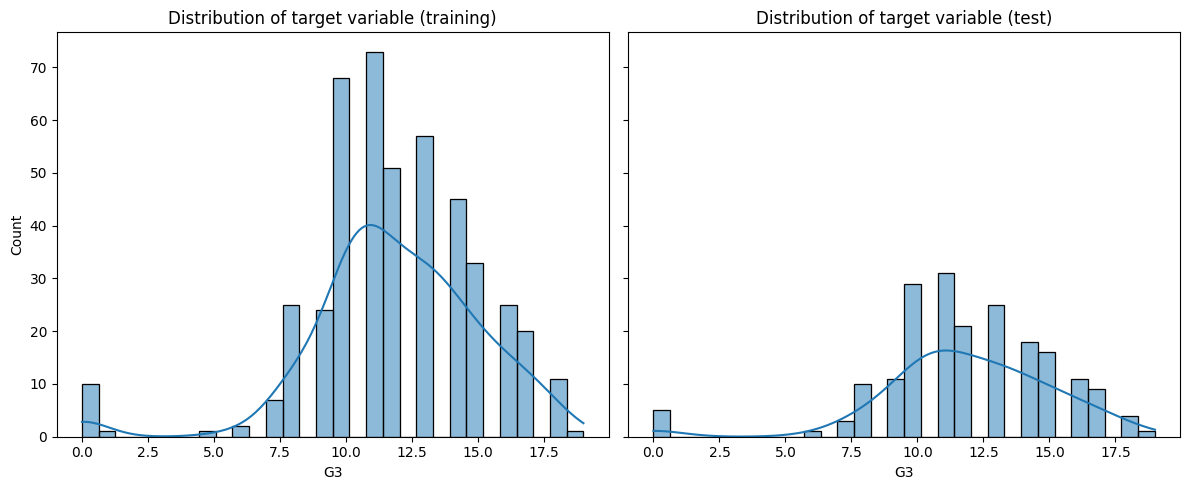

In [ ]:
# Checking if the split does not create bias into the target distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)

# Histogram for y_train
sns.histplot(y_train, bins=30, kde=True, ax=axes[0])
axes[0].set_title("Distribution of target variable (training)")

# Histogram for y_test
sns.histplot(y_test, bins=30, kde=True, ax=axes[1])
axes[1].set_title("Distribution of target variable (test)")

plt.tight_layout()
plt.show()

We can say the target variable is equally distributed on training and test set, according to the original distribution.

In [ ]:
# Even if it could not be the better one, we will choose the linear regression as first model, in order to have a baseline model to be compared.
model_LR = LinearRegression()

In [ ]:
# Fitting the model
clf = model_LR.fit(X_train, y_train)

In [ ]:
# Testing the model
y_pred_LR = clf.predict(X_test)

In [ ]:
# Calculating mean absolute error
MAE_LR = mean_absolute_error(y_test, y_pred_LR)

# Calculating mean squared error and root mean squared error
MSE_LR = mean_squared_error(y_test, y_pred_LR)
RMSE_LR = root_mean_squared_error(y_test, y_pred_LR)

# Calculating R2 score
R2_LR = r2_score(y_test, y_pred_LR)

In [ ]:
print('--- Linear Regression performances ---')
print(f'Mean absolute error with linear regression is: {MAE_LR:.2f}')
print(f'Mean squared error with linear regression is: {MSE_LR:.2f}')
print(f'Root mean squared error with linear regression is: {RMSE_LR:.2f}')
print(f'R2 score with linear regression is: {R2_LR:.2f}')

--- Linear Regression performances ---
Mean absolute error with linear regression is: 2.02
Mean squared error with linear regression is: 8.64
Root mean squared error with linear regression is: 2.94
R2 score with linear regression is: 0.19


This is just a baseline model, but we can say this is quite bad. Considering that the target has a range from 0 to 19, a mean absolute error of 2.02 is high. The root mean squared error, which square the residuals and penalize bigger errors, suggests that some outliers are getting the prediction worse.

The R2 of 0.19 which compares the prediction to a model that always predict the mean and it goes from -infinite to 1, explains that the prediction is not far better from just predicting the mean.

Let's try a more complex model to catch even non-linear relationships.

In [ ]:
# Creating the model
model = RandomForestRegressor(random_state=42) #random state in order to correctly reproduce the notebook

In [ ]:
def customCV (model, params, n_iter=10, cv=5, random_state=42):
    # Building a custom Randomized Search cross validation with the parameters above
    clf = RandomizedSearchCV(
        estimator=model,
        param_distributions=params,
        scoring="neg_mean_absolute_error", # Metric used to evaluate the model
        n_iter=n_iter,              # Number of random combinations to be tried
        cv=cv,                      # Number of folds (sample set) for cross-validation
        random_state=random_state,   # In order to reproduce the result
        n_jobs= -1 # Using all available cores
    )
    # Fitting the model
    clf = clf.fit(X_train, y_train)

    return clf.best_params_, clf.best_estimator_

I defined this custom function to cross-validate different models with model and parameters passed. The best model in validation will be chosen according to the MAE, as we have outliers which are affecting the distribution and other metrics would be sensible to them. Also, it will be possible to pass a number of iterations to be tried. We will start with 10 and they could be increased whether the best_params are badly changing at each iteration.

In [ ]:
# Creating dict of params to try in the model.
params = {
    'n_estimators': np.arange(100, 1000, 100),
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 4, 6],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
}

I will try different parameters for the model which are the main responsible one for Random Forest:

- n_estimators: number of trees of the model. I will try a range from 100 to 1000 with a step size of 100, in order to not have a too detailed search and a range too large.
- max_depth: the value None will not limit the tree and make it grow until each leef contains the minimum number of samples. However, we should test if limiting the tree, we get better results.
- min_samples_split: smaller values make the leef more specific trying to split further the samples, while larger values will avoid overfitting.
- min_samples_leaf: value 1 allows the tree to have leaves with just one sample, which could cause overfitting. Larger values make the tree more general.
- max_features: number of features to be considered from each tree in order to increase the variance among them.

We will start with few data and we will compare each result step by step, modifying the parameters if necessary, as some better parameter could be out of the previous range.

In [ ]:
best_params, best_model = customCV(model, params)
print(best_params)

{'n_estimators': np.int64(600), 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 10}


All the parameters are not close to the limit, except for min_samples_leaf. Let's increase its range. Also, I'm increasing the n_estimators' minimum value.

In [ ]:
params = {
    'n_estimators': np.arange(200, 1000, 100),
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 4, 6],
    'min_samples_leaf': [2, 4, 6],
    'max_features': ['sqrt', 'log2', None],
}

In [ ]:
best_params, best_model = customCV(model, params)
print(best_params)

{'n_estimators': np.int64(900), 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 20}


max_depth is 20, so we can remove the lower value and increase n_estimators' and min_samples_split's range.

In [ ]:
params = {
    'n_estimators': np.arange(600, 1200, 100),
    'max_depth': [10, 20, 30],
    'min_samples_split': [4, 6, 8],
    'min_samples_leaf': [2, 4, 6],
    'max_features': ['sqrt', 'log2', None],
}

In [ ]:
best_params, best_model = customCV(model, params)
print(best_params)

{'n_estimators': np.int64(700), 'min_samples_split': 8, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 20}


min_samples_split's range needs to be increased.

In [ ]:
params = {
    'n_estimators': np.arange(600, 1200, 100),
    'max_depth': [10, 20, 30],
    'min_samples_split': [6, 8, 10],
    'min_samples_leaf': [2, 4, 6],
    'max_features': ['sqrt', 'log2', None],
}

In [ ]:
best_params, best_model = customCV(model, params)
print(best_params)


{'n_estimators': np.int64(700), 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 20}


min_samples_split's range needs to be increased again.

In [ ]:
params = {
    'n_estimators': np.arange(600, 1200, 100),
    'max_depth': [10, 20, 30],
    'min_samples_split': [8, 10, 12],
    'min_samples_leaf': [2, 4, 6],
    'max_features': ['sqrt', 'log2', None],
}

best_params, best_model = customCV(model, params)
print(best_params)

{'n_estimators': np.int64(700), 'min_samples_split': 12, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 20}


In [ ]:
params = {
    'n_estimators': np.arange(600, 1200, 100),
    'max_depth': [10, 20, 30],
    'min_samples_split': [10, 12, 14, 16],
    'min_samples_leaf': [2, 4, 6],
    'max_features': ['sqrt', 'log2', None],
}

best_params, best_model = customCV(model, params)
print(best_params)

{'n_estimators': np.int64(600), 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 10}


Now our parameters are not close to the limit anymore. We can go ahead.

In [ ]:
# Checking if repeating CV with same params I get different results
for i in [0, 1, 2, 3, 4]:
    best_params, best_model = customCV(model, params)
    print(best_params)

{'n_estimators': np.int64(600), 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 10}
{'n_estimators': np.int64(600), 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 10}
{'n_estimators': np.int64(600), 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 10}
{'n_estimators': np.int64(600), 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 10}
{'n_estimators': np.int64(600), 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 10}


We can say the parameters are not changing, therefore the n_iter does not need to be increased (it would need if the best_params returned were always different). These are our best parameters and we have the best model, we can move forward testing it.

In [ ]:
# Testing the best model
y_pred_RF = best_model.predict(X_test)

# Calculating mean absolute error
MAE_RF = mean_absolute_error(y_test, y_pred_RF)

# Calculating R2 score
R2_RF = r2_score(y_test, y_pred_RF)

print('--- Random Forest performances ---')
print(f'Mean absolute error with Random Forest is: {MAE_RF:.2f} - against {MAE_LR:.2f} of Linear Regression')
print(f'R2 score with Random Forest is: {R2_RF:.2f} - against {R2_LR:.2f} of Linear Regression')

--- Random Forest performances ---
Mean absolute error with Random Forest is: 1.98 - against 2.02 of Linear Regression
R2 score with Random Forest is: 0.23 - against 0.19 of Linear Regression


The Random Forest model slightly outperforms Linear Regression, as indicated by both metrics:

The Mean Absolute Error (MAE) is lower (1.98 vs. 2.02), meaning Random Forest makes slightly more accurate predictions on average.

The R² score is higher (0.23 vs. 0.19), indicating that Random Forest explains a bit more variance in the data compared to Linear Regression.

However, the improvement is modest, suggesting that neither model is capturing the full complexity of the data. Further tuning or exploring more advanced models (e.g., Gradient Boosting) might be beneficial. We will try SVR first.

In [ ]:
# Scaling the data as SVR is sensible to the scale
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test) # Not fitting in order to leave the test set "clean"

y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).ravel()
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)).ravel()

# Creating the model
model = SVR()

params = {
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'C': np.logspace(-2, 3, 10),
    'epsilon': np.linspace(0.01, 1, 10),
    'gamma': ['scale', 'auto'] + list(np.logspace(-3, 2, 10))
}

- kernel (Kernel Type): Defines the transformation of input data. I will test 'linear', 'rbf' (for non-linear patterns), and 'poly' (for polynomial relationships).
- C (Regularization Parameter): Controls trade-off between minimizing training error and model simplicity. Higher values risk overfitting, lower values may underfit. I will test values from 0.01 to 1000 on log scale.
- epsilon (Margin of Tolerance): Specifies the margin where predictions are not penalized for being different from actual values. Higher values make the model ignore small variations. I will test values from 0.01 to 1 on linear scale.
- gamma (Kernel Coefficient): Defines how much influence a training example has. Small values consider distant points, large values make the model highly sensitive. I will test values from 0.001 to 100 on log scale.

In [ ]:
best_params, best_model_svr = customCV(model, params, 20) # Higher n_iter as we have a few values to test
print(best_params)

{'kernel': 'linear', 'gamma': np.float64(100.0), 'epsilon': np.float64(0.78), 'C': np.float64(0.03593813663804628)}


In [ ]:
# Testing the best model
y_pred_SVR = best_model_svr.predict(X_test)

# Calculating mean absolute error
MAE_SVR = mean_absolute_error(y_test, y_pred_SVR)

# Calculating R2 score
R2_SVR = r2_score(y_test, y_pred_SVR)

print('--- SVR performances ---')
print(f'Mean absolute error with SVR is: {MAE_SVR:.2f} - against {MAE_RF:.2f} of Random Forest - and {MAE_LR:.2f} of Linear Regression')
print(f'R2 score with SVR is: {R2_SVR:.2f} - against {R2_RF:.2f} of Random Forest - and {R2_LR:.2f} of Linear Regression')

--- SVR performances ---
Mean absolute error with SVR is: 2.05 - against 1.98 of Random Forest - and 2.02 of Linear Regression
R2 score with SVR is: 0.19 - against 0.23 of Random Forest - and 0.19 of Linear Regression


As we are focusing on the MAE (because of strong outliers affecting the results), we can say the best model is still Random Forest Regressor. Lastly, let's try another complex and advanced model: Gradient Boosting Regressor. This model is based on boosting techniques which combines different weak models to create a stronger one.

In [ ]:
model= GradientBoostingRegressor(random_state=42)

params = {
    'n_estimators': np.arange(100, 1000, 100),
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 3, 5],
    'subsample': [0.7, 0.8, 1.0],
    'max_features': ['sqrt', 'log2']
}

- n_estimators (Number of Trees): Defines the number of trees in the ensemble. Higher values improve accuracy but increase computation. Testing 100 to 1000.
- learning_rate (Step Size per Tree): Controls how much each tree contributes. Lower values prevent overfitting. Testing 0.01 to 0.1.
- max_depth (Tree Depth): Limits tree complexity. Shallow trees generalize better, deeper trees capture more patterns. Testing 3 to 7.
- min_samples_split (Min Samples to Split a Node): Prevents over-splitting. Higher values reduce overfitting. Testing 2 to 10.
- min_samples_leaf (Min Samples per Leaf Node): Ensures leaves have enough data. Higher values improve generalization. Testing 1 to 5.
- subsample (Fraction of Data per Tree): Reduces overfitting by using subsets. Testing 0.7 to 1.0.
- max_features (Features per Split): Controls feature selection at each split. "sqrt" and "log2" improve efficiency and prevent overfitting.

In [ ]:
best_params, best_model_gbr = customCV(model, params, 30) # More combinations to be tested
print(best_params)

{'subsample': 0.7, 'n_estimators': np.int64(200), 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 7, 'learning_rate': 0.01}


In [ ]:
# Adjusting the ranges according to the previous run
params = {
    'n_estimators': np.arange(100, 1000, 100),
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [5, 7, 9], # Increased
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 3, 5],
    'subsample': [0.7, 0.8, 1.0],
    'max_features': ['sqrt', 'log2']
}

In [ ]:
best_params, best_model_gbr = customCV(model, params, 30)
print(best_params)

{'subsample': 0.8, 'n_estimators': np.int64(300), 'min_samples_split': 10, 'min_samples_leaf': 5, 'max_features': 'log2', 'max_depth': 5, 'learning_rate': 0.01}


In [ ]:
# Adjusting the ranges according to the previous run
params = {
    'n_estimators': np.arange(100, 1000, 100),
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [5, 7, 9],
    'min_samples_split': [8, 10, 12, 14], # Increased
    'min_samples_leaf': [3, 5, 7], # Increased
    'subsample': [0.7, 0.8, 1.0],
    'max_features': ['sqrt', 'log2']
}

In [ ]:
best_params, best_model_gbr = customCV(model, params, 30)
print(best_params)

{'subsample': 0.8, 'n_estimators': np.int64(300), 'min_samples_split': 10, 'min_samples_leaf': 5, 'max_features': 'log2', 'max_depth': 5, 'learning_rate': 0.01}


We already have our best parameters, as the values are not close to the limit. Let's test it.

In [ ]:
# Testing the best model
y_pred_GBR = best_model_gbr.predict(X_test)

# Calculating mean absolute error
MAE_GBR = mean_absolute_error(y_test, y_pred_GBR)

# Calculating R2 score
R2_GBR = r2_score(y_test, y_pred_GBR)

print('--- Gradient Boosting Regressor performances ---')
print(f'Mean absolute error with GBR is: {MAE_GBR} - against {MAE_SVR:.2f} of SVR - against {MAE_RF:.2f} of Random Forest - and {MAE_LR:.2f} of Linear Regression')
print(f'R2 score with GBR is: {R2_GBR} - against {R2_SVR:.2f} of SVR - against {R2_RF:.2f} of Random Forest - and {R2_LR:.2f} of Linear Regression')

--- Gradient Boosting Regressor performances ---
Mean absolute error with GBR is: 1.995387963995819 - against 2.05 of SVR - against 1.98 of Random Forest - and 2.02 of Linear Regression
R2 score with GBR is: 0.224984272232859 - against 0.19 of SVR - against 0.23 of Random Forest - and 0.19 of Linear Regression


The Gradient Boosting Regressor (GBR) has similar results to Random Forest, outperforming SVR and Linear Regression. The best model remains Random Forest.

Let's plot the data to check where the models make more mistakes.

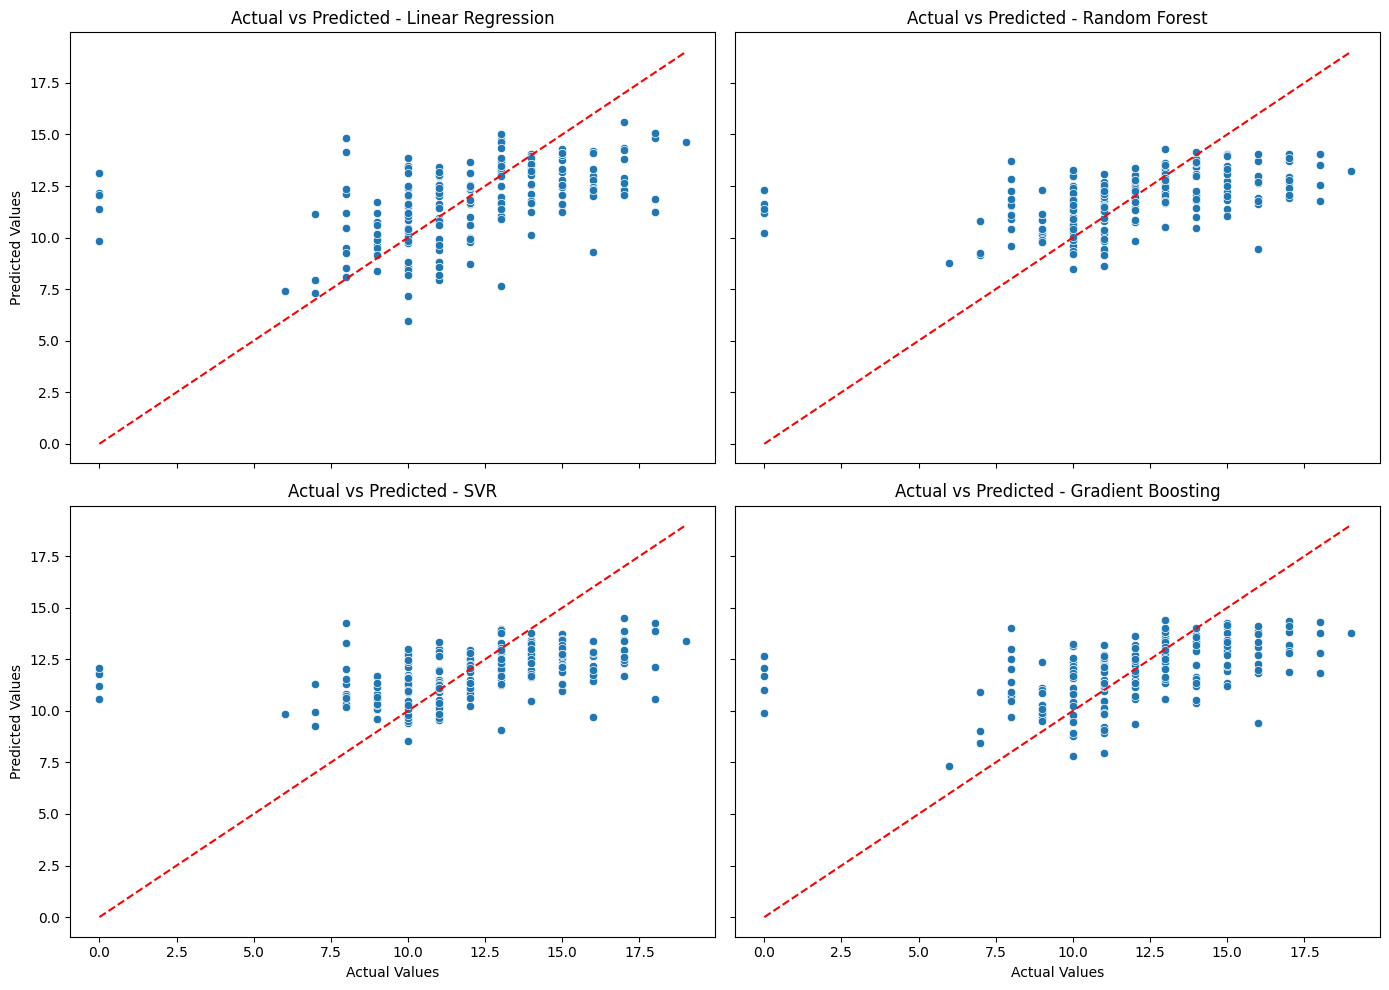

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharex=True, sharey=True)

# Scatterplot for LR
sns.scatterplot(x=y_test, y=y_pred_LR, ax=axes[0, 0])
axes[0, 0].set_title("Actual vs Predicted - Linear Regression")
axes[0, 0].set_xlabel("Actual Values")
axes[0, 0].set_ylabel("Predicted Values")
axes[0, 0].plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color="red", linestyle="--")  # Perfect line

# Scatterplot for RF
sns.scatterplot(x=y_test, y=y_pred_RF, ax=axes[0, 1])
axes[0, 1].set_title("Actual vs Predicted - Random Forest")
axes[0, 1].set_xlabel("Actual Values")
axes[0, 1].plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color="red", linestyle="--")

# Scatterplot for SVR
sns.scatterplot(x=y_test, y=y_pred_SVR, ax=axes[1, 0])
axes[1, 0].set_title("Actual vs Predicted - SVR")
axes[1, 0].set_xlabel("Actual Values")
axes[1, 0].set_ylabel("Predicted Values")
axes[1, 0].plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color="red", linestyle="--")

# Scatterplot for Gradient Boosting Regressor
sns.scatterplot(x=y_test, y=y_pred_GBR, ax=axes[1, 1])
axes[1, 1].set_title("Actual vs Predicted - Gradient Boosting")
axes[1, 1].set_xlabel("Actual Values")
axes[1, 1].plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color="red", linestyle="--")

plt.tight_layout()
plt.show()

Each plot displays the actual values (x-axis) against the predicted values (y-axis), with a red dashed line representing the ideal case where predictions perfectly match the actual values (i.e., a 45-degree line).

Observations:
- Linear Regression: The predicted values follow a roughly linear trend but show significant dispersion, indicating errors in the model's predictions.
- Random Forest & Gradient Boosting: Both models seem to perform better than linear regression, as the predictions are more closely clustered along the diagonal, but some deviation is still present.
- SVR: This model appears to predict a narrower range of values, with predictions clustering around a specific range, potentially indicating a bias or insufficient model flexibility.

Overall, tree-based models (Random Forest and Gradient Boosting) appear to provide more accurate predictions than Linear Regression and SVR. However, there are still noticeable deviations from the ideal line, suggesting potential room for improvement in the models.

**Random Forest seems to provide the most accurate predictions based on spread alignment.** All models exhibit some level of bias, particularly underestimating higher values. Further tuning or feature engineering could improve the results.

In [ ]:
# Printing models' results
data = {
    "Model": [
        "Random Forest",
        "Gradient Boosting Regressor",
        "Linear Regression",
        "Support Vector Regression"
    ],
    "MAE": [MAE_RF, MAE_GBR, MAE_LR, MAE_SVR],  # Mean Absolute Error
    "R²": [R2_RF, R2_GBR, R2_LR, R2_SVR]  # R-squared
}

df = pd.DataFrame(data)

print(tabulate(df, headers="keys", tablefmt="grid"))

+----+-----------------------------+---------+----------+
|    | Model                       |     MAE |       R² |
+====+=============================+=========+==========+
|  0 | Random Forest               | 1.97582 | 0.227482 |
+----+-----------------------------+---------+----------+
|  1 | Gradient Boosting Regressor | 1.99539 | 0.224984 |
+----+-----------------------------+---------+----------+
|  2 | Linear Regression           | 2.02261 | 0.186082 |
+----+-----------------------------+---------+----------+
|  3 | Support Vector Regression   | 2.05474 | 0.188483 |
+----+-----------------------------+---------+----------+


We will now analyze the features' importance for Linear Regression, Random Forest and Gradient Boosting Regressor.

In [ ]:
# Calculating features' importance for Linear Regression
lr_importance = np.abs(model_LR.coef_)

# Calculating features' importance for Random Forest
rf_importance = best_model.feature_importances_

# Calculating features' importance for GBR
gbr_importance = best_model_gbr.feature_importances_

# Calculating mutual information again
mi_scores = mutual_info_regression(X, y, random_state=42)

importance_df = pd.DataFrame({
    "Feature": X.columns,
    "MI": mi_scores,
    "RF": rf_importance,
    "LR": lr_importance,
    "GBR": gbr_importance
})

# Ordering for mean importance
importance_df["Avg Importance"] = importance_df[["MI", "RF", "LR", "GBR"]].mean(axis=1)
importance_df = importance_df.sort_values(by="Avg Importance", ascending=False).drop(columns=["Avg Importance"])

print(importance_df)

                        Feature        MI        RF        LR       GBR
11                       higher  0.083701  0.121092  2.645253  0.129238
8                school_support  0.000255  0.019920  1.740927  0.025036
0                     school_MS  0.038598  0.070761  1.132383  0.075536
21           father_job_teacher  0.003259  0.011553  1.110247  0.007663
1                           sex  0.028937  0.020464  0.732629  0.023101
25            reason_reputation  0.016749  0.025754  0.590681  0.028851
19           father_job_at_home  0.000000  0.005423  0.586798  0.002051
7                     studytime  0.004236  0.064427  0.450860  0.058410
26              guardian_father  0.030108  0.017714  0.457340  0.016691
20             father_job_other  0.000000  0.017097  0.478532  0.021929
24                 reason_other  0.005484  0.018340  0.439232  0.012968
27               guardian_other  0.019500  0.004805  0.442145  0.004533
5              father_education  0.049026  0.053432  0.283600  0

This table compares Mutual Information (MI), Random Forest (RF), Gradient Boosting Regressor (GBR) and Linear Regression (LR) Importance for different features.

Key Findings:

- "higher" is the most relevant feature across all methods, confirming its strong predictive power. It shows high importance in MI, RF, LR, and GBR, indicating that this feature is consistently important across both linear and non-linear models.
- "age" has the highest MI value but almost zero LR importance, suggesting a non-linear effect that is captured well by MI and GBR but not by LR. This highlights the non-linear relationship between age and the target.
- Some features such as "school_support" and "father_job_teacher" have low MI and RF scores but high LR importance, which suggests that these features may have a linear relationship with the target variable. However, their non-linear importance is lower in the RF and GBR models.
- "go_out" is ranked highly by RF and GBR but not by MI or LR. This suggests that the feature has a significant non-linear effect on the target variable, captured by tree-based models like RF and GBR, but not by MI (which might miss interaction effects) or LR (which assumes linear relationships).
- Several features have MI = 0, meaning they do not provide direct information about the target when measured by MI. However, RF, LR, and GBR assign them importance, likely due to interaction effects with other features. For instance, "father_job_at_home" and "family_support" show zero MI but have a non-zero importance in RF and GBR, implying that their effect may be hidden within interactions with other features.

We can say that there are pros and cons for each technique used to evaluate features' importance:
- Random Forest's and GBR's feature_importances_: it captures non-linear relationships, it's stronger with multicollinearity, but it's more sensible to categorical features with high more categories and with useless features
- Linear Regression's coef_: Independent from hyperparameter tuning and useful with linear data, but it's weak with non-linear data and multicollinearity

As a solution, we used (already done before to create the models) Mutual Information. It measures the dependency between a feature and the target variable. It quantifies how much knowing the value of a feature reduces the uncertainty about the target. Unlike traditional feature importance metrics, MI captures both linear and non-linear relationships.

## **Conclusion**

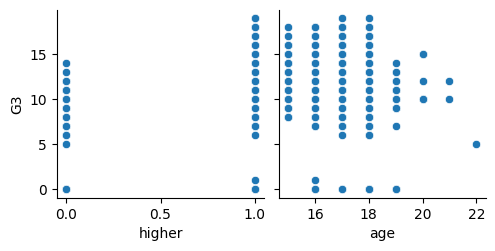

In [ ]:
# Plotting higher and age relationship with the target
cols = ['higher', 'age']
df = pd.concat([X, y], axis=1)
sns.pairplot(df, x_vars=df[cols], y_vars="G3", height=2.5)
plt.show()

The scatterplot shows the relationship between the final grade (G3) and two features: "higher" (aspiration for higher education) and "age".

**Left plot (higher vs. G3):**

Students who plan to pursue higher education (higher = 1) tend to have higher grades, while those who do not (higher = 0) show a wider spread, including many lower grades.

This suggests that motivation for higher education is correlated with academic performance.

**Right plot (age vs. G3):**

Most students fall within the 16-19 age range, with younger students tending to have higher grades.

There is a slight decline in grades for students older than 18, which could indicate academic struggles, grade repetition, or late school entry.

These patterns confirm the importance of educational aspirations and suggest that age might have a non-linear relationship with performance.